### Package import and Data Loading

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

import torch
import random
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

torch.Size([64, 1, 28, 28]) torch.Size([64])


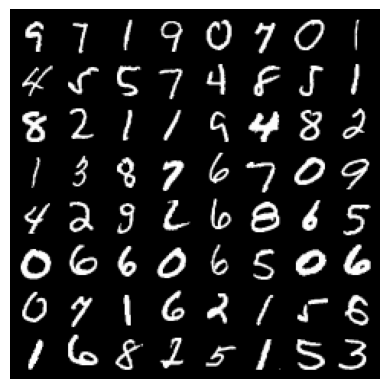

In [9]:
# 2. Data loading
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

x, y = next(iter(train_loader))
print(x.shape, y.shape)

npimg = torchvision.utils.make_grid(x).numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.axis('off')
plt.show()

### Function Definitions:

In [3]:
def plot_training_curves(loss_curve, accuracy_curve, epoch_markers, epochs, baseline):
    """
    Plots loss and accuracy curves for training monitoring.

    Args:
        loss_curve (list): List of recorded loss values.
        accuracy_curve (list): List of recorded accuracy values.
        epoch_markers (list): Indices where epochs ended.
        epochs (int): Number of epochs.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    fig.suptitle("Training Curves")

    # Loss curve
    ax1.set_title("Cross-Entropy Loss")
    ax1.set_xlabel("Epoch")
    ax1.set_xticks(epoch_markers, tuple(range(1, epochs + 1)))
    ax1.plot(loss_curve, label="Loss", color="C0")
    ax1.scatter(epoch_markers, [loss_curve[i] for i in epoch_markers], color="C0")

    # Accuracy curve
    ax2.set_title("Accuracy on Test Dataset (%)")
    ax2.set_xlabel("Epoch")
    ax2.plot(range(1, epochs + 1), accuracy_curve, label="Accuracy", color="C1", marker="o")
    # ax2.hlines(baseline, 1, epochs, linestyle="dashed", color="gray", alpha=0.5)

    fig.tight_layout()
    plt.show()

In [4]:
def train_model(model, optimizer, criterion, train_loader, test_loader, epochs):
    train_losses, test_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for x, y in train_loader:
            outputs = model(x)
            loss = criterion(outputs, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Average loss
        train_losses.append(running_loss / len(train_loader))

        # Evaluate accuracy
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for x, y in test_loader:
                outputs = model(x)
                _, predicted = torch.max(outputs.data, 1)
                total += y.size(0)
                correct += (predicted == y).sum().item()
        test_accuracies.append(100 * correct / total)

    return train_losses, test_accuracies


In [5]:
def plot_compare_training_curves(loss_bn, loss_no_bn, acc_bn, acc_no_bn, epochs):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    fig.suptitle("BatchNorm vs No BatchNorm – Training Curves")

    # ---- Loss ----
    ax1.plot(range(1, epochs + 1), loss_no_bn, label="No BN", color="C0", marker="o")
    ax1.plot(range(1, epochs + 1), loss_bn, label="With BN", color="C1", marker="o")
    ax1.set_title("Cross-Entropy Loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.legend()

    # ---- Accuracy ----
    ax2.plot(range(1, epochs + 1), acc_no_bn, label="No BN", color="C0", marker="o")
    ax2.plot(range(1, epochs + 1), acc_bn, label="With BN", color="C1", marker="o")
    ax2.set_title("Test Accuracy (%)")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy (%)")
    ax2.legend()

    fig.tight_layout()
    plt.show()


In [6]:
def show_fixed_predictions(model, images, labels):
    model.eval()
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

    fig = plt.figure(figsize=(12, 10))
    rows, cols = 5, 6  # 5x6 = 30 images
    for i in range(rows * cols):
        ax = fig.add_subplot(rows, cols, i + 1)
        img = images[i].squeeze().numpy()
        ax.imshow(img, cmap='gray')
        color = 'green' if predicted[i] == labels[i] else 'red'
        ax.set_title(f"P:{predicted[i].item()}\nT:{labels[i].item()}", color=color)
        ax.axis('off')

    plt.tight_layout()
    plt.show()


In [7]:
def visualize_first_layer_weights(model, input_shape=(1, 28, 28), nrow=8, ncol=8, figsize=(8, 8)):
    """
    Visualizes the first linear layer weights of a fully-connected network trained on 2D image data.
    """
    # Find the first Linear layer
    linear = None
    for layer in model.net:
        if isinstance(layer, torch.nn.Linear):
            linear = layer
            break

    if linear is None:
        raise ValueError("No Linear layer found in the model.")

    # Extract weights (shape: [out_features, in_features])
    W = linear.weight.detach().cpu().clone()

    # Normalize weights for visualization
    W = W - W.min()
    W = W / W.max()

    # Reshape weights to image format
    W = W.reshape(-1, *input_shape)  # (num_neurons, 1, 28, 28)

    # Show only first nrow*ncol filters
    W = W[:nrow * ncol]

    # Create grid
    grid = torchvision.utils.make_grid(W, nrow=nrow, normalize=False, pad_value=1.0)
    grid = grid.permute(1, 2, 0)

    # Plot grid
    plt.figure(figsize=figsize)
    plt.imshow(grid, cmap='gray')
    plt.axis('off')
    plt.title("First Linear Layer Weights (as Images)")
    plt.show()


In [8]:
def visualize_linear1_weights_2d(network, input_shape, nrow=4, ncol=4, figsize=(8, 8)):
    """
    Visualizes the first linear layer weights, assuming the network processes 2D images.

    Args:
        network (torch.nn.Module): The neural network with a MLP whose first layer will be visualized.
        input_shape (tuple): Shape of the input to the linear layer (C, H, W).
        nrow (int): Number of filters per row in the grid.
        ncol (int): Number of filters per column in the grid.
        figsize (tuple): Size of the matplotlib figure.
    """
    # Find first linear layer
    linear = None
    for i, layer in enumerate(network.net):
        if isinstance(layer, torch.nn.Linear):
            linear = layer
            break
    if linear is None:
        raise ValueError("No linear layer found in the network.")

    # Extract and normalize weights
    W = linear.weight.cpu().detach().clone()
    W = W - W.min()
    W = W / W.max()
    W = W.reshape(-1, *input_shape)

    if W.shape[0] > nrow * ncol:
        print(f"Warning: Layer has {W.shape[0]} features, but only first {nrow * ncol} will be displayed.")

    W = W[:nrow * ncol]

    # Create grids for visualization
    grid = torchvision.utils.make_grid(W, nrow=nrow).permute(1, 2, 0)

    # Plot the results
    _, ax = plt.subplots(1, 1, figsize=figsize)
    ax.imshow(grid)
    ax.axis('off')

    plt.tight_layout()
    plt.show()

### Model Definition, Running and Results:

In [ ]:
# Hyperparameters
batch_size = 64
learning_rate = 0.01
epochs = 5

# Define model, loss and optimizer

class NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        return self.net(x)



class NN_BN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        return self.net(x)

criterion = nn.CrossEntropyLoss()

model_no_bn = NN()
optimizer_1 = optim.Adam(model_no_bn.parameters(), lr=learning_rate)

model_bn = NN_BN()
optimizer_2 = optim.Adam(model_bn.parameters(), lr=learning_rate)


In [ ]:
# Individual Training loop for NO_BN

pbar1 = tqdm(range(epochs), desc="Epochs", position=0)
for epoch in pbar1:
    model_no_bn.train()
    running_loss = 0.0

    pbar2 = tqdm(train_loader, desc="Batches", position=1)
    for x, y in pbar2:
        # Forward pass
        outputs = model_no_bn(x)
        loss = criterion(outputs, y)

        # Backward and optimize
        optimizer_1.zero_grad()
        loss.backward()
        optimizer_1.step()

        running_loss += loss.item()

        pbar2.set_description(f"Loss: {loss.item():.4f}")

    pbar1.set_description(f"Loss: {running_loss/len(train_loader):.4f}")

# Test accuracy for NO_BN

model_no_bn.eval()
correct = 0
total = 0
with torch.no_grad():
    for x, y in test_loader:
        outputs = model_no_bn(x)
        _, predicted = torch.max(outputs.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()

print(f'Test Accuracy: {100 * correct / total:.2f}%')


In [ ]:
# Individual Training loop for BN

pbar1 = tqdm(range(epochs), desc="Epochs", position=0)
for epoch in pbar1:
    model_bn.train()
    running_loss = 0.0

    pbar2 = tqdm(train_loader, desc="Batches", position=1)
    for x, y in pbar2:
        # Forward pass
        outputs = model_bn(x)
        loss = criterion(outputs, y)

        # Backward and optimize
        optimizer_2.zero_grad()
        loss.backward()
        optimizer_2.step()

        running_loss += loss.item()

        pbar2.set_description(f"Loss: {loss.item():.4f}")

    pbar1.set_description(f"Loss: {running_loss/len(train_loader):.4f}")

# Test accuracy for BN
model_bn.eval()
correct = 0
total = 0
with torch.no_grad():
    for x, y in test_loader:
        outputs = model_bn(x)
        _, predicted = torch.max(outputs.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()

print(f'Test Accuracy: {100 * correct / total:.2f}%')


In [ ]:
# Train model without BatchNorm
loss_no_bn, acc_no_bn = train_model(model_no_bn, optimizer_1, criterion, train_loader, test_loader, epochs)

# Train model with BatchNorm
loss_bn, acc_bn = train_model(model_bn, optimizer_2, criterion, train_loader, test_loader, epochs)


In [ ]:
plot_compare_training_curves(
    loss_bn=loss_bn,
    loss_no_bn=loss_no_bn,
    acc_bn=acc_bn,
    acc_no_bn=acc_no_bn,
    epochs=epochs
)


In [ ]:
# Get full test dataset as tensors (no DataLoader batching)
test_images = test_dataset.data.float() / 255.0  # shape [10000, 28, 28]
test_labels = test_dataset.targets

# Pick 10 random but *fixed* indices
fixed_indices = random.sample(range(len(test_dataset)), 30)

# Optional: if you want truly reproducible runs, fix the seed
# torch.manual_seed(0)
# random.seed(0)

# Extract the fixed examples
fixed_x = test_images[fixed_indices]
fixed_y = test_labels[fixed_indices]

# Add channel dimension (for model input)
fixed_x = fixed_x.unsqueeze(1)  # [10, 1, 28, 28]

print("Fixed sample indices:", fixed_indices)


In [ ]:
# Show prediction result for non normalized model
show_fixed_predictions(model_no_bn, fixed_x, fixed_y)


In [ ]:
# Show prediction result for Batch normalized model
show_fixed_predictions(model_bn, fixed_x, fixed_y)


In [ ]:
# Visualize linear weights for Non normalized model
visualize_linear1_weights_2d(model_no_bn, input_shape=(1, 28, 28))


In [ ]:
# Visualize linear weights for Batch normalized model
visualize_linear1_weights_2d(model_bn, input_shape=(1, 28, 28))
